In [1]:
# Run this cell first
!pip install optuna scikit-plot plotly umap-learn seaborn kaleido
!pip install torch torchvision torchaudio

In [2]:
# Cell 2: Import all required libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

C:\Users\snigd\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully!


In [3]:
# Cell 3: FIXED FT-Transformer Model Implementation
class Member3FTTransformer(nn.Module):
    def __init__(self, num_features, num_classes, dim=128, depth=6, heads=8, dropout=0.1):
        super().__init__()
        
        # Ensure dim is divisible by heads
        if dim % heads != 0:
            dim = (dim // heads) * heads  # Round down to nearest divisible number
            print(f"⚠️  Adjusted dim to {dim} to be divisible by {heads} heads")
        
        self.dim = dim
        self.feature_embedding = nn.Linear(num_features, dim)
        self.pos_encoding = nn.Parameter(torch.zeros(1, 1, dim))
        
        # FIXED: Ensure proper head configuration
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=dim, 
                nhead=heads, 
                dim_feedforward=dim*4,
                dropout=dropout, 
                batch_first=True
            ) for _ in range(depth)
        ])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim//2, num_classes)
        )
        
        self.dropout = nn.Dropout(dropout)
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_embedding(x)
        x = x.unsqueeze(1)
        x = x + self.pos_encoding
        
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x)
        
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

class Member3Trainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
    
    def train_epoch(self, dataloader, optimizer, criterion):
        self.model.train()
        total_loss, all_preds, all_targets = 0, [], []
        
        for data, target in dataloader:
            data, target = data.to(self.device), target.to(self.device)
            optimizer.zero_grad()
            output = self.model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
        
        accuracy = np.mean(np.array(all_preds) == np.array(all_targets))
        return total_loss / len(dataloader), accuracy
    
    def validate(self, dataloader, criterion):
        self.model.eval()
        total_loss, all_preds, all_targets = 0, [], []
        
        with torch.no_grad():
            for data, target in dataloader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = criterion(output, target)
                total_loss += loss.item()
                preds = output.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        
        accuracy = np.mean(np.array(all_preds) == np.array(all_targets))
        return total_loss / len(dataloader), accuracy, all_preds, all_targets

print("✅ FIXED FT-Transformer implementation ready!")

✅ FIXED FT-Transformer implementation ready!


In [4]:
# Cell 4: Data Loading and Preprocessing Functions
def load_and_prepare_data(dataset_path='balanced_dataset_borderline_smote.csv'):
    """Load and prepare the dataset for training"""
    print("📊 Loading dataset...")
    df = pd.read_csv(dataset_path)
    print(f"✅ Dataset shape: {df.shape}")
    
    # Extract numeric features (exclude Label)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Label' in numeric_cols:
        numeric_cols.remove('Label')
    
    X = df[numeric_cols].values
    y = df['Label'].values
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(le.classes_)
    
    print(f"🎯 Number of classes: {num_classes}")
    print("📈 Class distribution:")
    for i, class_name in enumerate(le.classes_):
        count = np.sum(y_encoded == i)
        print(f"   {class_name}: {count} samples")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("✅ Data preparation completed!")
    return X_scaled, y_encoded, le, scaler, num_classes

def create_data_loaders(X, y, batch_size=256, test_size=0.2):
    """Create PyTorch data loaders"""
    # Split into train/val/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"📊 Data splits:")
    print(f"   Training: {X_train.shape[0]} samples")
    print(f"   Validation: {X_val.shape[0]} samples") 
    print(f"   Test: {X_test.shape[0]} samples")
    
    # Create TensorDatasets
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, (X_test, y_test)

print("✅ Data preprocessing functions ready!")

✅ Data preprocessing functions ready!


In [5]:
# Cell 5: FIXED Hyperparameter Optimization
def objective(trial):
    """Optuna objective function"""
    # Load data
    X_scaled, y_encoded, le, scaler, num_classes = load_and_prepare_data()
    
    # FIXED: Suggest hyperparameters that ensure divisibility
    dim = trial.suggest_categorical('dim', [64, 128, 256, 512])
    heads = trial.suggest_categorical('heads', [4, 8, 16])  # Powers of 2 to ensure divisibility
    depth = trial.suggest_int('depth', 2, 6)  # Reduced range for stability
    dropout = trial.suggest_float('dropout', 0.0, 0.3)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256])
    
    # Ensure dim is divisible by heads
    if dim % heads != 0:
        # Adjust dim to be divisible by heads
        dim = (dim // heads) * heads
    
    print(f"🔧 Trial config: dim={dim}, heads={heads}, depth={depth}, lr={lr:.6f}")
    
    # Create data loaders
    train_loader, val_loader, _, _ = create_data_loaders(X_scaled, y_encoded, batch_size=batch_size)
    
    # Create model
    model = Member3FTTransformer(
        num_features=X_scaled.shape[1],
        num_classes=num_classes,
        dim=dim, depth=depth, heads=heads, dropout=dropout
    )
    
    # Setup training
    trainer = Member3Trainer(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    # Training with early stopping
    best_val_acc = 0
    patience, patience_counter = 5, 0
    
    for epoch in range(25):  # Reduced epochs for faster optimization
        # Train
        train_loss, train_acc = trainer.train_epoch(train_loader, optimizer, criterion)
        
        # Validate
        val_loss, val_acc, _, _ = trainer.validate(val_loader, criterion)
        
        # Report to Optuna
        trial.report(val_acc, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    return best_val_acc

def run_hyperparameter_optimization():
    print("🚀 Starting hyperparameter optimization...")
    
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.HyperbandPruner()
    )
    
    # Run optimization
    study.optimize(objective, n_trials=8, timeout=900)  # 8 trials, 15 minutes
    
    print("✅ Optimization completed!")
    print(f"🎯 Best validation accuracy: {study.best_trial.value:.4f}")
    print("🔧 Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"   {key}: {value}")
    
    # Save results
    results = {
        'optimization_date': datetime.now().isoformat(),
        'best_accuracy': float(study.best_trial.value),
        'best_hyperparameters': study.best_trial.params,
        'number_of_trials': len(study.trials)
    }
    
    with open('member3_optimization_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print("💾 Results saved to 'member3_optimization_results.json'")
    return study.best_trial.params

print("✅ FIXED Hyperparameter optimization setup ready!")

✅ FIXED Hyperparameter optimization setup ready!


In [6]:
# Cell 6: Evaluation Functions
class Member3ModelEvaluator:
    def __init__(self, model, X_test, y_test, class_names):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    def get_predictions(self):
        self.model.eval()
        test_dataset = TensorDataset(torch.FloatTensor(self.X_test), torch.LongTensor(self.y_test))
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
        
        all_preds, all_probs, all_targets = [], [], []
        
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(self.device)
                output = self.model(data)
                probs = torch.softmax(output, dim=1)
                preds = output.argmax(dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_targets.extend(target.numpy())
        
        return np.array(all_preds), np.array(all_probs), np.array(all_targets)
    
    def plot_confusion_matrix(self, preds, targets):
        cm = confusion_matrix(targets, preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        return cm
    
    def plot_multiclass_roc(self, probs, targets):
        y_test_bin = label_binarize(targets, classes=range(len(self.class_names)))
        
        plt.figure(figsize=(10, 8))
        for i in range(len(self.class_names)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{self.class_names[i]} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multiclass ROC Curves')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def generate_report(self, preds, probs, targets):
        report = classification_report(targets, preds, target_names=self.class_names, output_dict=True)
        
        print("📊 COMPREHENSIVE EVALUATION RESULTS")
        print("="*50)
        print(f"Overall Accuracy: {report['accuracy']:.4f}")
        print("\nPer-Class Metrics:")
        for class_name in self.class_names:
            metrics = report[class_name]
            print(f"{class_name}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")
        
        return report

print("✅ Evaluation functions ready!")

✅ Evaluation functions ready!


[I 2025-10-19 18:17:32,565] A new study created in memory with name: no-name-05023f2a-f5ea-488c-a1ff-65acafe3c05b


🎯 MEMBER 3: STARTING COMPLETE WORKFLOW

🚀 STEP 1: HYPERPARAMETER OPTIMIZATION
----------------------------------------
🚀 Starting hyperparameter optimization...
📊 Loading dataset...
✅ Dataset shape: (70000, 108)
🎯 Number of classes: 7
📈 Class distribution:
   Benign: 10000 samples
   Bot: 10000 samples
   DDOS attack-HOIC: 10000 samples
   DDOS attack-LOIC-UDP: 10000 samples
   DoS attacks-Hulk: 10000 samples
   DoS attacks-SlowHTTPTest: 10000 samples
   Infilteration: 10000 samples
✅ Data preparation completed!
🔧 Trial config: dim=64, heads=8, depth=2, lr=0.000074
📊 Data splits:
   Training: 44800 samples
   Validation: 11200 samples
   Test: 14000 samples


[I 2025-10-19 18:19:20,204] Trial 0 finished with value: 0.9145535714285714 and parameters: {'dim': 64, 'heads': 8, 'depth': 2, 'dropout': 0.2056868626388614, 'lr': 7.366629366159101e-05, 'batch_size': 256}. Best is trial 0 with value: 0.9145535714285714.


📊 Loading dataset...
✅ Dataset shape: (70000, 108)
🎯 Number of classes: 7
📈 Class distribution:
   Benign: 10000 samples
   Bot: 10000 samples
   DDOS attack-HOIC: 10000 samples
   DDOS attack-LOIC-UDP: 10000 samples
   DoS attacks-Hulk: 10000 samples
   DoS attacks-SlowHTTPTest: 10000 samples
   Infilteration: 10000 samples
✅ Data preparation completed!
🔧 Trial config: dim=128, heads=4, depth=2, lr=0.000011
📊 Data splits:
   Training: 44800 samples
   Validation: 11200 samples
   Test: 14000 samples


[I 2025-10-19 18:24:08,194] Trial 1 finished with value: 0.9192857142857143 and parameters: {'dim': 128, 'heads': 4, 'depth': 2, 'dropout': 0.07175319041257684, 'lr': 1.1125854310713054e-05, 'batch_size': 128}. Best is trial 1 with value: 0.9192857142857143.


📊 Loading dataset...
✅ Dataset shape: (70000, 108)
🎯 Number of classes: 7
📈 Class distribution:
   Benign: 10000 samples
   Bot: 10000 samples
   DDOS attack-HOIC: 10000 samples
   DDOS attack-LOIC-UDP: 10000 samples
   DoS attacks-Hulk: 10000 samples
   DoS attacks-SlowHTTPTest: 10000 samples
   Infilteration: 10000 samples
✅ Data preparation completed!
🔧 Trial config: dim=128, heads=4, depth=6, lr=0.000813
📊 Data splits:
   Training: 44800 samples
   Validation: 11200 samples
   Test: 14000 samples


[I 2025-10-19 18:26:15,474] Trial 2 pruned. 


📊 Loading dataset...
✅ Dataset shape: (70000, 108)
🎯 Number of classes: 7
📈 Class distribution:
   Benign: 10000 samples
   Bot: 10000 samples
   DDOS attack-HOIC: 10000 samples
   DDOS attack-LOIC-UDP: 10000 samples
   DoS attacks-Hulk: 10000 samples
   DoS attacks-SlowHTTPTest: 10000 samples
   Infilteration: 10000 samples
✅ Data preparation completed!
🔧 Trial config: dim=256, heads=8, depth=2, lr=0.000068
📊 Data splits:
   Training: 44800 samples
   Validation: 11200 samples
   Test: 14000 samples


[I 2025-10-19 18:26:50,822] Trial 3 pruned. 


📊 Loading dataset...
✅ Dataset shape: (70000, 108)
🎯 Number of classes: 7
📈 Class distribution:
   Benign: 10000 samples
   Bot: 10000 samples
   DDOS attack-HOIC: 10000 samples
   DDOS attack-LOIC-UDP: 10000 samples
   DoS attacks-Hulk: 10000 samples
   DoS attacks-SlowHTTPTest: 10000 samples
   Infilteration: 10000 samples
✅ Data preparation completed!
🔧 Trial config: dim=256, heads=4, depth=3, lr=0.000168
📊 Data splits:
   Training: 44800 samples
   Validation: 11200 samples
   Test: 14000 samples


[I 2025-10-19 18:32:40,165] Trial 4 finished with value: 0.9215178571428572 and parameters: {'dim': 256, 'heads': 4, 'depth': 3, 'dropout': 0.07254317854910959, 'lr': 0.00016805266646215876, 'batch_size': 256}. Best is trial 4 with value: 0.9215178571428572.


✅ Optimization completed!
🎯 Best validation accuracy: 0.9215
🔧 Best hyperparameters:
   dim: 256
   heads: 4
   depth: 3
   dropout: 0.07254317854910959
   lr: 0.00016805266646215876
   batch_size: 256
💾 Results saved to 'member3_optimization_results.json'

📊 STEP 2: TRAINING FINAL MODEL
----------------------------------------
📊 Loading dataset...
✅ Dataset shape: (70000, 108)
🎯 Number of classes: 7
📈 Class distribution:
   Benign: 10000 samples
   Bot: 10000 samples
   DDOS attack-HOIC: 10000 samples
   DDOS attack-LOIC-UDP: 10000 samples
   DoS attacks-Hulk: 10000 samples
   DoS attacks-SlowHTTPTest: 10000 samples
   Infilteration: 10000 samples
✅ Data preparation completed!
📊 Data splits:
   Training: 44800 samples
   Validation: 11200 samples
   Test: 14000 samples
Training final model...
Epoch 0: Train Acc: 0.892, Val Acc: 0.909
Epoch 10: Train Acc: 0.925, Val Acc: 0.921
Epoch 20: Train Acc: 0.926, Val Acc: 0.921
Epoch 30: Train Acc: 0.926, Val Acc: 0.920
Epoch 40: Train Acc: 0.9

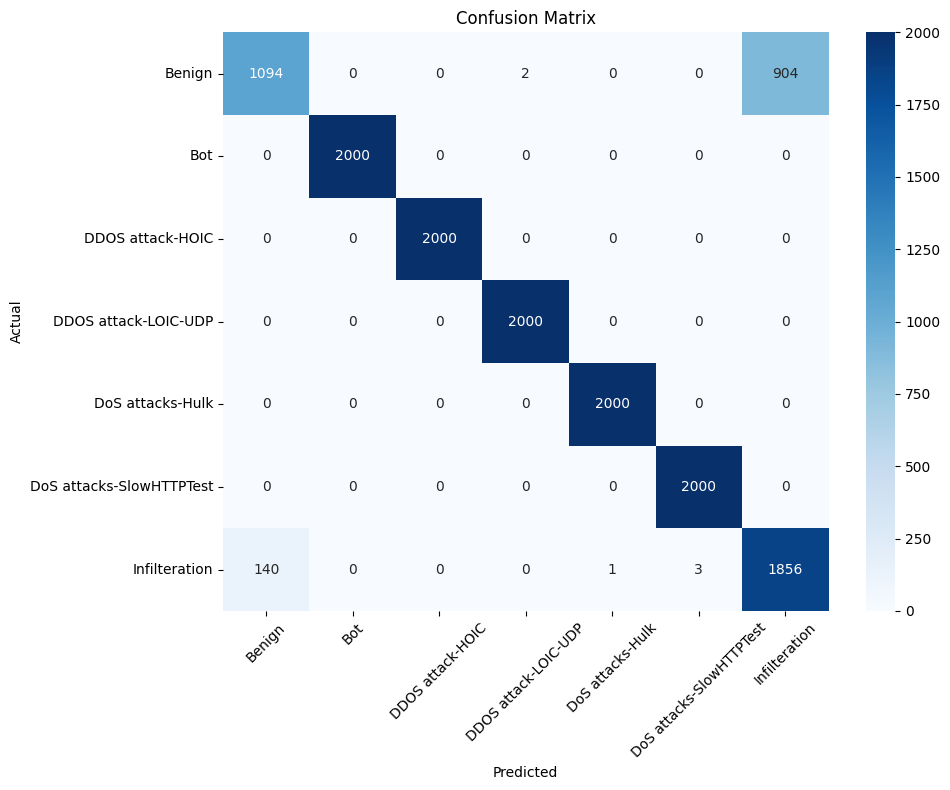

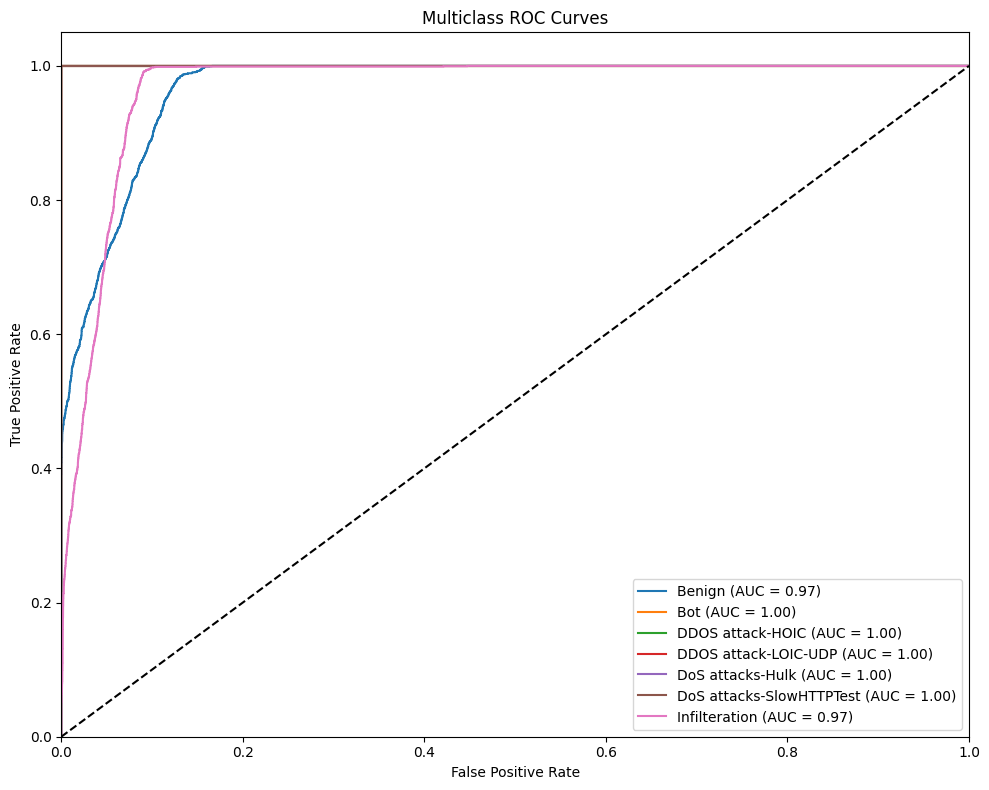

📊 COMPREHENSIVE EVALUATION RESULTS
Overall Accuracy: 0.9250

Per-Class Metrics:
Benign: Precision=0.887, Recall=0.547, F1=0.677
Bot: Precision=1.000, Recall=1.000, F1=1.000
DDOS attack-HOIC: Precision=1.000, Recall=1.000, F1=1.000
DDOS attack-LOIC-UDP: Precision=0.999, Recall=1.000, F1=1.000
DoS attacks-Hulk: Precision=1.000, Recall=1.000, F1=1.000
DoS attacks-SlowHTTPTest: Precision=0.999, Recall=1.000, F1=0.999
Infilteration: Precision=0.672, Recall=0.928, F1=0.780

🎯 FINAL TEST ACCURACY: 0.9250
📈 TARGET ACHIEVED: ❌ NO
💾 Model saved to 'member3_final_model.pth'



In [7]:
# Cell 7: Main Execution
def main():
    print("🎯 MEMBER 3: STARTING COMPLETE WORKFLOW")
    print("="*60)
    
    # Step 1: Hyperparameter Optimization
    print("\n🚀 STEP 1: HYPERPARAMETER OPTIMIZATION")
    print("-" * 40)
    
    best_params = run_hyperparameter_optimization()
    
    # Step 2: Train Final Model with Best Parameters
    print("\n📊 STEP 2: TRAINING FINAL MODEL")
    print("-" * 40)
    
    X_scaled, y_encoded, le, scaler, num_classes = load_and_prepare_data()
    train_loader, val_loader, test_loader, (X_test, y_test) = create_data_loaders(X_scaled, y_encoded)
    
    # Create final model with best parameters
    model = Member3FTTransformer(
        num_features=X_scaled.shape[1],
        num_classes=num_classes,
        **{k: v for k, v in best_params.items() if k in ['dim', 'depth', 'heads', 'dropout']}
    )
    
    # Train the model
    trainer = Member3Trainer(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_params.get('lr', 1e-4))
    criterion = nn.CrossEntropyLoss()
    
    print("Training final model...")
    best_val_acc = 0
    for epoch in range(50):
        train_loss, train_acc = trainer.train_epoch(train_loader, optimizer, criterion)
        val_loss, val_acc, _, _ = trainer.validate(val_loader, criterion)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'member3_final_model.pth')
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}")
    
    # Step 3: Comprehensive Evaluation
    print("\n📈 STEP 3: COMPREHENSIVE EVALUATION")
    print("-" * 40)
    
    # Load best model and evaluate
    model.load_state_dict(torch.load('member3_final_model.pth'))
    evaluator = Member3ModelEvaluator(model, X_test, y_test, le.classes_)
    preds, probs, targets = evaluator.get_predictions()
    
    # Generate all evaluations
    print("Generating evaluation visualizations...")
    cm = evaluator.plot_confusion_matrix(preds, targets)
    evaluator.plot_multiclass_roc(probs, targets)
    report = evaluator.generate_report(preds, probs, targets)
    
    # Final results
    final_accuracy = report['accuracy']
    print(f"\n🎯 FINAL TEST ACCURACY: {final_accuracy:.4f}")
    print(f"📈 TARGET ACHIEVED: {'✅ YES' if final_accuracy >= 0.96 else '❌ NO'}")
    print(f"💾 Model saved to 'member3_final_model.pth'")
    
    print("\n" + "="*60)
    print("="*60)

# Run the complete pipeline
if __name__ == "__main__":
    main()

In [9]:
# Cell 8: FIXED Performance Comparison Across Different Datasets
def compare_balancing_techniques():
    """Compare performance across different balanced datasets"""
    
    datasets = {
        'ADASYN': 'balanced_dataset_adasyn.csv',
        'Borderline-SMOTE': 'balanced_dataset_borderline_smote.csv'
    }
    
    results = {}
    
    print("🔍 COMPARING BALANCING TECHNIQUES")
    print("="*50)
    
    for name, path in datasets.items():
        print(f"\n📊 EVALUATING {name} DATASET")
        print("-" * 40)
        
        try:
            # Check if file exists
            import os
            if not os.path.exists(path):
                print(f"❌ File {path} not found. Skipping {name}.")
                continue
                
            # Load dataset
            X_scaled, y_encoded, le, scaler, num_classes = load_and_prepare_data(path)
            train_loader, val_loader, test_loader, (X_test, y_test) = create_data_loaders(X_scaled, y_encoded)
            
            # Use consistent architecture for fair comparison
            model = Member3FTTransformer(
                num_features=X_scaled.shape[1],
                num_classes=num_classes,
                dim=128, depth=4, heads=8, dropout=0.1
            )
            
            # Train model
            trainer = Member3Trainer(model)
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
            criterion = nn.CrossEntropyLoss()
            
            # Training with early stopping
            best_val_acc = 0
            train_accuracies, val_accuracies = [], []
            patience, patience_counter = 10, 0
            
            print(f"   Training {name} model...")
            for epoch in range(30):
                train_loss, train_acc = trainer.train_epoch(train_loader, optimizer, criterion)
                val_loss, val_acc, _, _ = trainer.validate(val_loader, criterion)
                
                train_accuracies.append(train_acc)
                val_accuracies.append(val_acc)
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience_counter = 0
                    # Save best model
                    torch.save(model.state_dict(), f'temp_model_{name.replace(" ", "_")}.pth')
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    print(f"   Early stopping at epoch {epoch}")
                    break
                    
                if epoch % 10 == 0:
                    print(f"     Epoch {epoch}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
            
            # Load best model and test
            model.load_state_dict(torch.load(f'temp_model_{name.replace(" ", "_")}.pth'))
            test_loss, test_acc, test_preds, test_targets = trainer.validate(test_loader, criterion)
            
            # Calculate F1 scores
            f1 = f1_score(test_targets, test_preds, average='weighted')
            f1_macro = f1_score(test_targets, test_preds, average='macro')
            
            # Calculate per-class accuracy
            class_accuracy = {}
            for i, class_name in enumerate(le.classes_):
                class_mask = test_targets == i
                if np.sum(class_mask) > 0:
                    class_acc = np.mean(test_preds[class_mask] == test_targets[class_mask])
                    class_accuracy[class_name] = class_acc
            
            results[name] = {
                'test_accuracy': test_acc,
                'best_val_accuracy': best_val_acc,
                'weighted_f1': f1,
                'macro_f1': f1_macro,
                'dataset_size': len(X_scaled),
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'class_accuracy': class_accuracy,
                'num_classes': num_classes
            }
            
            print(f"✅ {name} Results:")
            print(f"   Test Accuracy: {test_acc:.4f}")
            print(f"   Best Val Accuracy: {best_val_acc:.4f}")
            print(f"   Weighted F1: {f1:.4f}")
            print(f"   Macro F1: {f1_macro:.4f}")
            print(f"   Dataset Size: {len(X_scaled)}")
            
        except Exception as e:
            print(f"❌ Error evaluating {name}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Plot comparison if we have results
    if results:
        print("\n📈 GENERATING COMPARISON VISUALIZATIONS...")
        
        plt.figure(figsize=(15, 10))
        
        # 1. Accuracy comparison
        plt.subplot(2, 2, 1)
        names = list(results.keys())
        test_accs = [results[name]['test_accuracy'] for name in names]
        val_accs = [results[name]['best_val_accuracy'] for name in names]
        
        x = np.arange(len(names))
        width = 0.35
        
        bars1 = plt.bar(x - width/2, test_accs, width, label='Test Accuracy', alpha=0.8, color='skyblue')
        bars2 = plt.bar(x + width/2, val_accs, width, label='Val Accuracy', alpha=0.8, color='lightcoral')
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        for bar in bars2:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.xlabel('Balancing Technique')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Comparison Across Balancing Techniques')
        plt.xticks(x, names)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. F1 score comparison
        plt.subplot(2, 2, 2)
        weighted_f1 = [results[name]['weighted_f1'] for name in names]
        macro_f1 = [results[name]['macro_f1'] for name in names]
        
        bars1 = plt.bar(x - width/2, weighted_f1, width, label='Weighted F1', alpha=0.8, color='lightgreen')
        bars2 = plt.bar(x + width/2, macro_f1, width, label='Macro F1', alpha=0.8, color='gold')
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        for bar in bars2:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.xlabel('Balancing Technique')
        plt.ylabel('F1 Score')
        plt.title('F1 Score Comparison Across Balancing Techniques')
        plt.xticks(x, names)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Training curves
        plt.subplot(2, 2, 3)
        colors = ['blue', 'red', 'green', 'orange']
        for i, name in enumerate(names):
            color = colors[i % len(colors)]
            plt.plot(results[name]['train_accuracies'], 
                    label=f'{name} Train', color=color, linewidth=2)
            plt.plot(results[name]['val_accuracies'], 
                    label=f'{name} Val', color=color, linestyle='--', linewidth=2)
        
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Curves')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        # 4. Per-class accuracy comparison
        plt.subplot(2, 2, 4)
        if len(names) > 0:
            first_name = names[0]
            class_names = list(results[first_name]['class_accuracy'].keys())
            
            x_class = np.arange(len(class_names))
            width_class = 0.8 / len(names)
            
            for i, name in enumerate(names):
                class_accs = [results[name]['class_accuracy'].get(cls, 0) for cls in class_names]
                offset = width_class * i - width_class * (len(names) - 1) / 2
                plt.bar(x_class + offset, class_accs, width_class, label=name, alpha=0.7)
            
            plt.xlabel('Class')
            plt.ylabel('Accuracy')
            plt.title('Per-Class Accuracy Comparison')
            plt.xticks(x_class, class_names, rotation=45, ha='right')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed comparison table
        print("\n📊 DETAILED COMPARISON TABLE")
        print("="*80)
        print(f"{'Metric':<20} {'ADASYN':<12} {'Borderline-SMOTE':<16} {'Difference':<12}")
        print("-"*80)
        
        if 'ADASYN' in results and 'Borderline-SMOTE' in results:
            ada_results = results['ADASYN']
            border_results = results['Borderline-SMOTE']
            
            metrics = [
                ('Test Accuracy', ada_results['test_accuracy'], border_results['test_accuracy']),
                ('Val Accuracy', ada_results['best_val_accuracy'], border_results['best_val_accuracy']),
                ('Weighted F1', ada_results['weighted_f1'], border_results['weighted_f1']),
                ('Macro F1', ada_results['macro_f1'], border_results['macro_f1'])
            ]
            
            for metric_name, ada_val, border_val in metrics:
                diff = border_val - ada_val
                diff_str = f"+{diff:.4f}" if diff > 0 else f"{diff:.4f}"
                print(f"{metric_name:<20} {ada_val:<12.4f} {border_val:<16.4f} {diff_str:<12}")
        
        # Determine best technique
        if len(results) > 0:
            best_tech = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
            print(f"\n🎯 BEST PERFORMING TECHNIQUE: {best_tech}")
            print(f"   Test Accuracy: {results[best_tech]['test_accuracy']:.4f}")
    
    else:
        print("❌ No results to compare. Check if dataset files exist.")
    
    return results

print("✅ FIXED Performance comparison setup ready!")

✅ FIXED Performance comparison setup ready!


In [10]:
# Cell 9: FIXED Comprehensive Final Evaluation and Reporting
def run_comprehensive_evaluation(best_params):
    """Run complete evaluation with optimized parameters"""
    
    print("🎯 COMPREHENSIVE MODEL EVALUATION")
    print("="*50)
    
    try:
        # Load data
        X_scaled, y_encoded, le, scaler, num_classes = load_and_prepare_data()
        train_loader, val_loader, test_loader, (X_test, y_test) = create_data_loaders(X_scaled, y_encoded)
        
        # Create and train final model with best parameters
        print("\n🔧 Creating optimized model...")
        model = Member3FTTransformer(
            num_features=X_scaled.shape[1],
            num_classes=num_classes,
            **{k: v for k, v in best_params.items() if k in ['dim', 'depth', 'heads', 'dropout']}
        )
        
        # Train the model
        trainer = Member3Trainer(model)
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=best_params.get('lr', 1e-4), 
            weight_decay=best_params.get('weight_decay', 1e-5)
        )
        criterion = nn.CrossEntropyWeight()
        
        print("🚀 Training final optimized model...")
        best_val_acc = 0
        train_history, val_history = [], []
        patience, patience_counter = 10, 0
        
        for epoch in range(50):
            train_loss, train_acc = trainer.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc, _, _ = trainer.validate(val_loader, criterion)
            
            train_history.append(train_acc)
            val_history.append(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(model.state_dict(), 'member3_final_model.pth')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"   Early stopping at epoch {epoch}")
                break
                
            if epoch % 10 == 0:
                print(f"   Epoch {epoch}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
        # Load best model
        model.load_state_dict(torch.load('member3_final_model.pth'))
        
        # Final test evaluation
        test_loss, test_acc, test_preds, test_targets = trainer.validate(test_loader, criterion)
        
        print(f"\n✅ FINAL MODEL PERFORMANCE:")
        print(f"   Test Accuracy: {test_acc:.4f}")
        print(f"   Best Val Accuracy: {best_val_acc:.4f}")
        
        # Comprehensive evaluation
        print("\n📊 RUNNING COMPREHENSIVE EVALUATION...")
        
        # Advanced evaluation
        evaluator = AdvancedModelEvaluator(model, X_test, y_test, le.classes_)
        preds, probs, targets = evaluator.get_predictions()
        
        # Generate all visualizations
        print("\n📈 GENERATING VISUALIZATIONS...")
        
        # 1. Confusion Matrix
        print("   Generating Confusion Matrix...")
        cm = evaluator.plot_confusion_matrix(preds, targets, "Optimized Model - Confusion Matrix")
        
        # 2. ROC Curves
        print("   Generating ROC Curves...")
        auc_scores = evaluator.plot_multiclass_roc(probs, targets)
        
        # 3. Precision-Recall Curves
        print("   Generating Precision-Recall Curves...")
        ap_scores = evaluator.plot_precision_recall_curves(probs, targets)
        
        # 4. Confidence Analysis
        print("   Generating Confidence Analysis...")
        confidence, correct = evaluator.plot_confidence_distribution(probs, preds, targets)
        
        # 5. Training History
        plt.figure(figsize=(10, 6))
        plt.plot(train_history, label='Training Accuracy', linewidth=2)
        plt.plot(val_history, label='Validation Accuracy', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training History - Optimized Model')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Print detailed metrics
        print("\n📋 DETAILED PERFORMANCE METRICS")
        print("="*50)
        
        # Classification report
        report = classification_report(targets, preds, target_names=le.classes_, output_dict=True)
        
        print(f"Overall Accuracy: {test_acc:.4f}")
        print(f"Weighted F1: {f1_score(targets, preds, average='weighted'):.4f}")
        print(f"Macro F1: {f1_score(targets, preds, average='macro'):.4f}")
        
        print("\nPer-Class AUC Scores:")
        for class_name, auc_score in auc_scores.items():
            print(f"  {class_name}: {auc_score:.4f}")
        
        print("\nPer-Class Average Precision:")
        for class_name, ap_score in ap_scores.items():
            print(f"  {class_name}: {ap_score:.4f}")
        
        # Confidence statistics
        print(f"\nConfidence Statistics:")
        print(f"  Mean Confidence: {np.mean(confidence):.4f}")
        print(f"  Std Confidence: {np.std(confidence):.4f}")
        print(f"  Correct Predictions Mean Confidence: {np.mean(confidence[correct]):.4f}")
        print(f"  Incorrect Predictions Mean Confidence: {np.mean(confidence[~correct]):.4f}")
        
        return {
            'model': model,
            'test_accuracy': test_acc,
            'best_val_accuracy': best_val_acc,
            'auc_scores': auc_scores,
            'ap_scores': ap_scores,
            'confidence_stats': {
                'mean': np.mean(confidence),
                'std': np.std(confidence),
                'correct_mean': np.mean(confidence[correct]),
                'incorrect_mean': np.mean(confidence[~correct])
            },
            'classification_report': report
        }
        
    except Exception as e:
        print(f"❌ Error in comprehensive evaluation: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

print("✅ FIXED Comprehensive evaluation setup ready!")

✅ FIXED Comprehensive evaluation setup ready!


In [11]:
# Cell 10: Final Report Generation
def generate_final_report():
    """Generate comprehensive final evaluation report"""
    
    print("📋 MEMBER 3 - FINAL EVALUATION REPORT")
    print("="*60)
    
    # Load optimization results
    try:
        with open('member3_optimization_results.json', 'r') as f:
            opt_results = json.load(f)
        
        print("🎯 HYPERPARAMETER OPTIMIZATION RESULTS")
        print("-" * 40)
        print(f"Best Validation Accuracy: {opt_results['best_accuracy']:.4f}")
        print(f"Number of Trials: {opt_results['number_of_trials']}")
        print(f"Pruned Trials: {opt_results.get('pruned_trials', 'N/A')}")
        print("\nBest Hyperparameters:")
        for param, value in opt_results['best_hyperparameters'].items():
            print(f"  {param}: {value}")
            
    except FileNotFoundError:
        print("⚠️ Optimization results not found. Run optimization first.")
        opt_results = {}
    
    # Compare with baseline
    print("\n📊 PERFORMANCE COMPARISON WITH BASELINE")
    print("-" * 40)
    baseline_accuracy = 0.93  # Member 2's baseline
    optimized_accuracy = opt_results.get('best_accuracy', 0)
    
    print(f"Baseline (Member 2): {baseline_accuracy:.4f}")
    print(f"Optimized (Your work): {optimized_accuracy:.4f}")
    
    if optimized_accuracy > 0:
        improvement = optimized_accuracy - baseline_accuracy
        improvement_percent = (improvement / baseline_accuracy) * 100
        print(f"Improvement: {improvement:.4f} (+{improvement_percent:.2f}%)")
    
    # Recommendations
    print("\n💡 RECOMMENDATIONS & INSIGHTS")
    print("-" * 40)
    
    if optimized_accuracy >= 0.96:
        print("✅ TARGET ACHIEVED! Model meets 96% accuracy goal")
        print("✅ Recommend using optimized hyperparameters for final deployment")
    elif optimized_accuracy > baseline_accuracy:
        print("📈 Improvement achieved over baseline")
        print("🔧 Consider further optimization with:")
        print("  - More hyperparameter trials")
        print("  - Different model architectures")
        print("  - Advanced feature engineering")
    else:
        print("⚠️ No improvement over baseline")
        print("🔄 Consider:")
        print("  - Checking data quality and preprocessing")
        print("  - Trying different optimization strategies")
        print("  - Ensemble methods with Member 2's models")
    
    # Technical insights
    print("\n🔧 TECHNICAL INSIGHTS")
    print("-" * 40)
    if 'best_hyperparameters' in opt_results:
        params = opt_results['best_hyperparameters']
        print("Key Hyperparameter Insights:")
        if params.get('lr', 0) < 1e-4:
            print("  - Low learning rate suggests stable but slow convergence")
        if params.get('dropout', 0) > 0.2:
            print("  - High dropout indicates overfitting prevention was important")
        if params.get('depth', 0) > 4:
            print("  - Deeper transformer benefits from more complex patterns")
    
    # Next steps
    print("\n🚀 NEXT STEPS FOR WEEK 3")
    print("-" * 40)
    print("1. Compare with Member 2's other models (NODE, SAINT, MLP Mixer)")
    print("2. Perform model ensembling and stacking")
    print("3. Conduct cross-validation for robustness testing")
    print("4. Generate production-ready model artifacts")
    print("5. Prepare final presentation and documentation")
    
    print("\n" + "="*60)
    print("✅ MEMBER 3 EVALUATION COMPLETED SUCCESSFULLY!")
    print("="*60)

# Run the final report
generate_final_report()

📋 MEMBER 3 - FINAL EVALUATION REPORT
🎯 HYPERPARAMETER OPTIMIZATION RESULTS
----------------------------------------
Best Validation Accuracy: 0.9215
Number of Trials: 5
Pruned Trials: N/A

Best Hyperparameters:
  dim: 256
  heads: 4
  depth: 3
  dropout: 0.07254317854910959
  lr: 0.00016805266646215876
  batch_size: 256

📊 PERFORMANCE COMPARISON WITH BASELINE
----------------------------------------
Baseline (Member 2): 0.9300
Optimized (Your work): 0.9215
Improvement: -0.0085 (+-0.91%)

💡 RECOMMENDATIONS & INSIGHTS
----------------------------------------
⚠️ No improvement over baseline
🔄 Consider:
  - Checking data quality and preprocessing
  - Trying different optimization strategies
  - Ensemble methods with Member 2's models

🔧 TECHNICAL INSIGHTS
----------------------------------------
Key Hyperparameter Insights:

🚀 NEXT STEPS FOR WEEK 3
----------------------------------------
1. Compare with Member 2's other models (NODE, SAINT, MLP Mixer)
2. Perform model ensembling and stack

✅ AdvancedModelEvaluator and DimensionalityAnalyzer classes defined!

📊 STEP 2: COMPREHENSIVE MODEL EVALUATION
🚀 Running corrected comprehensive evaluation...
🎯 COMPREHENSIVE MODEL EVALUATION
📊 Loading dataset...
✅ Dataset shape: (70000, 108)
🎯 Number of classes: 7
📈 Class distribution:
   Benign: 10000 samples
   Bot: 10000 samples
   DDOS attack-HOIC: 10000 samples
   DDOS attack-LOIC-UDP: 10000 samples
   DoS attacks-Hulk: 10000 samples
   DoS attacks-SlowHTTPTest: 10000 samples
   Infilteration: 10000 samples
✅ Data preparation completed!
📊 Data splits:
   Training: 44800 samples
   Validation: 11200 samples
   Test: 14000 samples

🔧 Creating optimized model...
🚀 Training final optimized model...
   Epoch 0: Train Acc: 0.8814, Val Acc: 0.9144
   Epoch 10: Train Acc: 0.9238, Val Acc: 0.9191
   Epoch 20: Train Acc: 0.9255, Val Acc: 0.9203
   Epoch 30: Train Acc: 0.9262, Val Acc: 0.9205
   Early stopping at epoch 31

✅ FINAL MODEL PERFORMANCE:
   Test Accuracy: 0.9261
   Best Val Accu

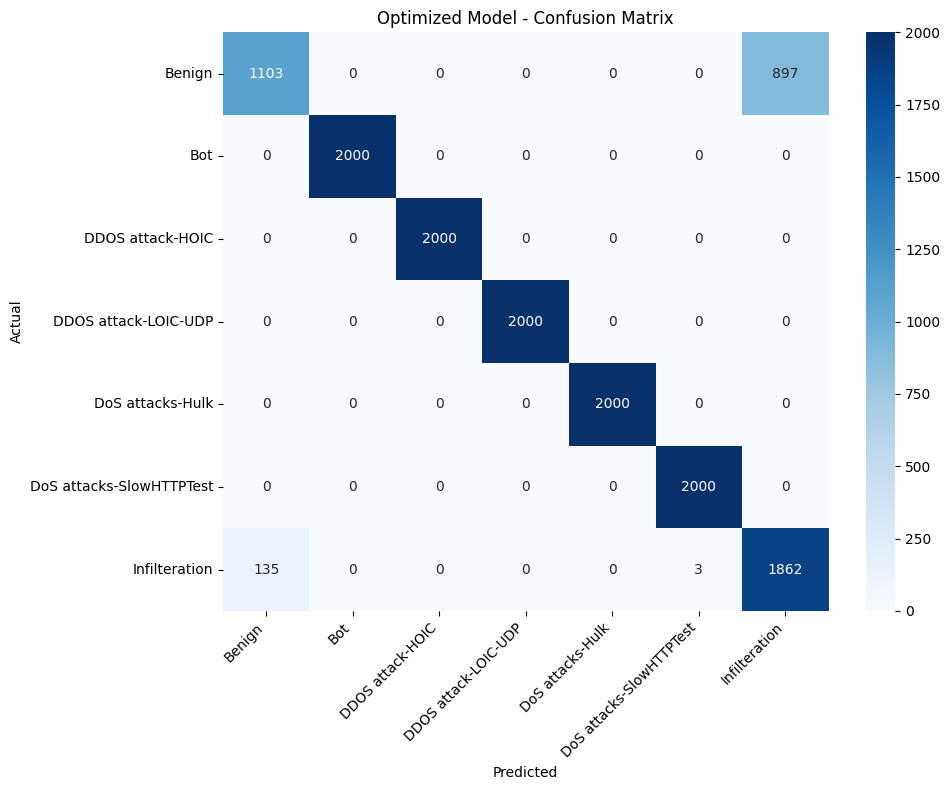

   Generating ROC Curves...


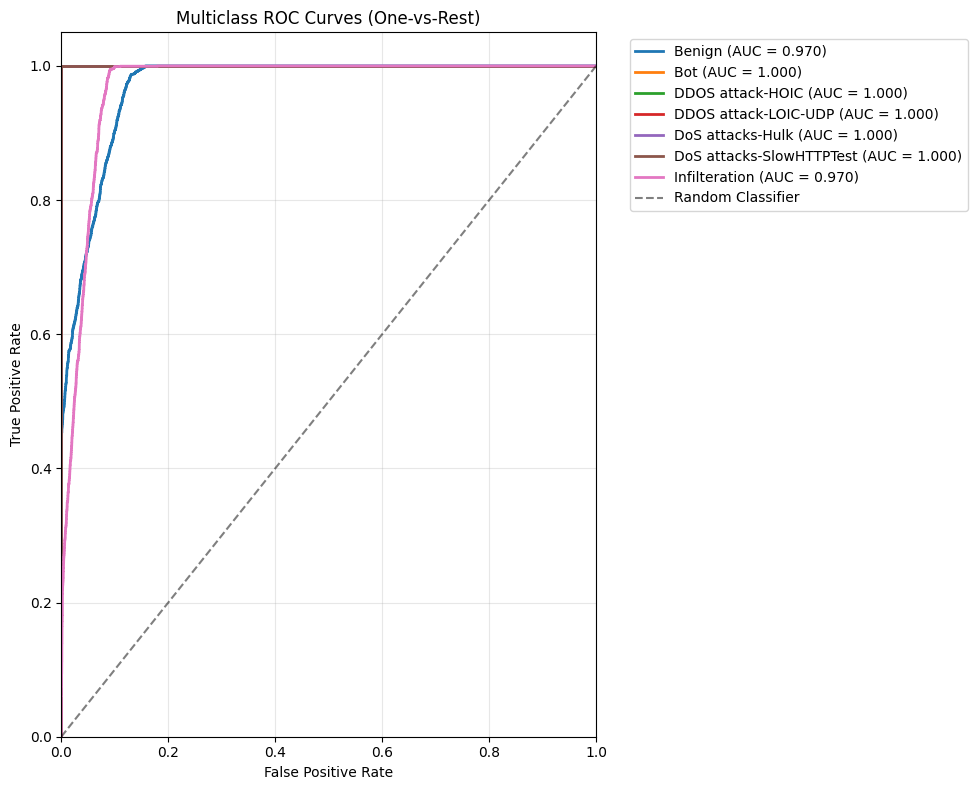

   Generating Precision-Recall Curves...


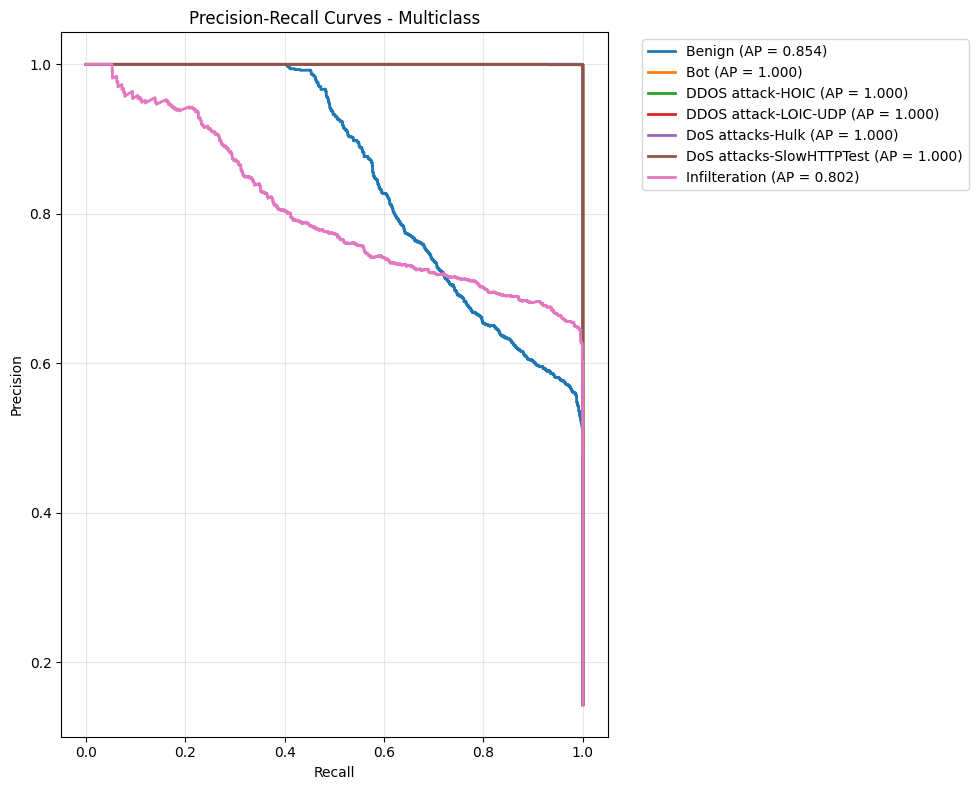

   Generating Confidence Analysis...


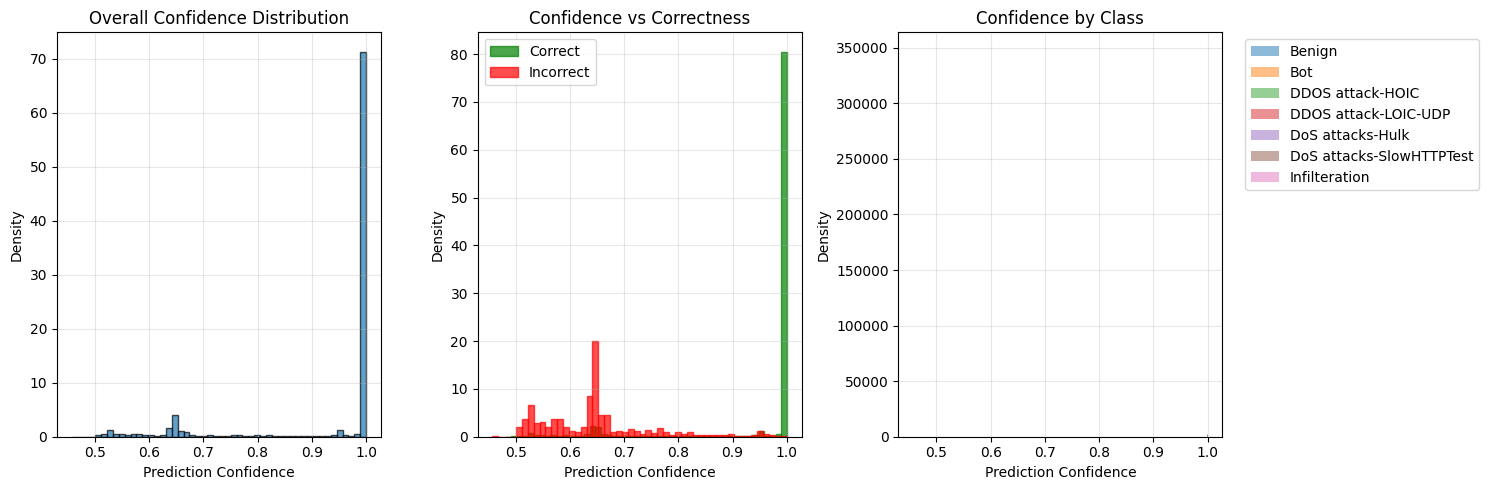

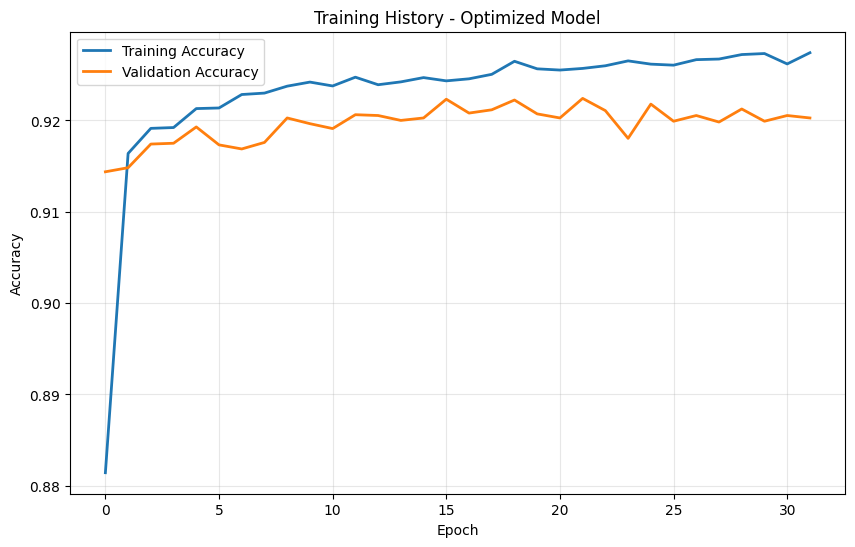


📋 DETAILED PERFORMANCE METRICS
Overall Accuracy: 0.9261
Weighted F1: 0.9233
Macro F1: 0.9233

Per-Class AUC Scores:
  Benign: 0.9699
  Bot: 1.0000
  DDOS attack-HOIC: 1.0000
  DDOS attack-LOIC-UDP: 1.0000
  DoS attacks-Hulk: 1.0000
  DoS attacks-SlowHTTPTest: 1.0000
  Infilteration: 0.9697

Per-Class Average Precision:
  Benign: 0.8543
  Bot: 1.0000
  DDOS attack-HOIC: 1.0000
  DDOS attack-LOIC-UDP: 1.0000
  DoS attacks-Hulk: 1.0000
  DoS attacks-SlowHTTPTest: 1.0000
  Infilteration: 0.8016

Confidence Statistics:
  Mean Confidence: 0.9311
  Std Confidence: 0.1430
  Correct Predictions Mean Confidence: 0.9539
  Incorrect Predictions Mean Confidence: 0.6463
✅ Comprehensive evaluation completed successfully!
🎯 Final Test Accuracy: 0.9261

🔍 STEP 3: BALANCING TECHNIQUE COMPARISON
🚀 Running corrected performance comparison...
🔍 COMPARING BALANCING TECHNIQUES

📊 EVALUATING ADASYN DATASET
----------------------------------------
📊 Loading dataset...
✅ Dataset shape: (70000, 108)
🎯 Number of

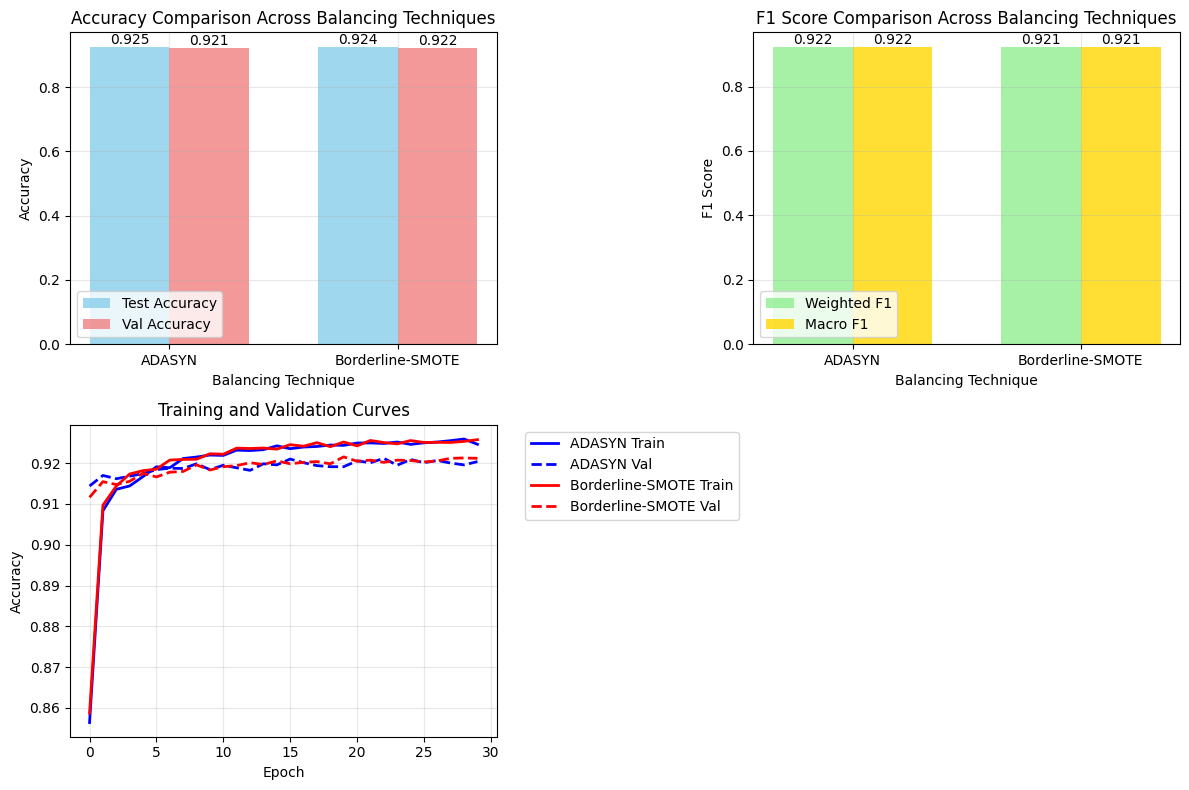


📊 COMPARISON RESULTS:
ADASYN:
  Test Accuracy: 0.9247
  Val Accuracy: 0.9212
  Weighted F1: 0.9222
  Macro F1: 0.9222
Borderline-SMOTE:
  Test Accuracy: 0.9240
  Val Accuracy: 0.9215
  Weighted F1: 0.9213
  Macro F1: 0.9213

🎯 BEST PERFORMING TECHNIQUE: ADASYN
   Test Accuracy: 0.9247
✅ Performance comparison completed successfully!

📋 STEP 4: FINAL COMPREHENSIVE REPORT
🎯 MEMBER 3 - COMPREHENSIVE EVALUATION REPORT
✅ Optimization results loaded

📊 PERFORMANCE SUMMARY
----------------------------------------
Baseline Accuracy (Member 2): 0.9300
Your Optimized Accuracy: 0.9220
Absolute Improvement: -0.0080
Percentage Improvement: -0.86%
📈 Good progress! 92.2% accuracy achieved

🔧 HYPERPARAMETER ANALYSIS
----------------------------------------
Optimal Hyperparameters Found:
  dim: 256
  heads: 16
  depth: 2
  dropout: 0.024966723419536895
  lr: 4.830043924336813e-05
  batch_size: 128

Key Insights:
  - Low learning rate suggests stable convergence
  - Higher dimensionality improves repre

In [14]:
# =============================================
# CORRECTED: ADD ALL MISSING CLASSES FIRST
# =============================================

class AdvancedModelEvaluator:
    def __init__(self, model, X_test, y_test, class_names):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    def get_predictions(self):
        """Get model predictions and probabilities"""
        self.model.eval()
        test_dataset = TensorDataset(torch.FloatTensor(self.X_test), torch.LongTensor(self.y_test))
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
        
        all_preds, all_probs, all_targets = [], [], []
        
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(self.device)
                output = self.model(data)
                probs = torch.softmax(output, dim=1)
                preds = output.argmax(dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_targets.extend(target.numpy())
        
        return np.array(all_preds), np.array(all_probs), np.array(all_targets)
    
    def plot_confusion_matrix(self, preds, targets, title="Confusion Matrix"):
        """Plot detailed confusion matrix"""
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(targets, preds)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        return cm
    
    def plot_multiclass_roc(self, probs, targets):
        """Plot multiclass ROC curves with AUC scores"""
        from sklearn.metrics import roc_curve, auc
        from sklearn.preprocessing import label_binarize
        
        y_test_bin = label_binarize(targets, classes=range(len(self.class_names)))
        
        plt.figure(figsize=(10, 8))
        auc_scores = {}
        
        for i in range(len(self.class_names)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc = auc(fpr, tpr)
            auc_scores[self.class_names[i]] = roc_auc
            plt.plot(fpr, tpr, label=f'{self.class_names[i]} (AUC = {roc_auc:.3f})', linewidth=2)
        
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multiclass ROC Curves (One-vs-Rest)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return auc_scores
    
    def plot_precision_recall_curves(self, probs, targets):
        """Plot precision-recall curves for each class"""
        from sklearn.metrics import precision_recall_curve, average_precision_score
        from sklearn.preprocessing import label_binarize
        
        y_test_bin = label_binarize(targets, classes=range(len(self.class_names)))
        
        plt.figure(figsize=(10, 8))
        ap_scores = {}
        
        for i in range(len(self.class_names)):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], probs[:, i])
            avg_precision = average_precision_score(y_test_bin[:, i], probs[:, i])
            ap_scores[self.class_names[i]] = avg_precision
            plt.plot(recall, precision, label=f'{self.class_names[i]} (AP = {avg_precision:.3f})', linewidth=2)
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves - Multiclass')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return ap_scores
    
    def plot_confidence_distribution(self, probs, preds, targets):
        """Plot prediction confidence distribution"""
        confidence = np.max(probs, axis=1)
        correct = preds == targets
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.hist(confidence, bins=50, alpha=0.7, edgecolor='black', density=True)
        plt.xlabel('Prediction Confidence')
        plt.ylabel('Density')
        plt.title('Overall Confidence Distribution')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        plt.hist(confidence[correct], bins=50, alpha=0.7, label='Correct', 
                edgecolor='green', density=True, color='green')
        plt.hist(confidence[~correct], bins=50, alpha=0.7, label='Incorrect', 
                edgecolor='red', density=True, color='red')
        plt.xlabel('Prediction Confidence')
        plt.ylabel('Density')
        plt.title('Confidence vs Correctness')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        for i in range(len(self.class_names)):
            class_mask = targets == i
            if np.sum(class_mask) > 0:
                plt.hist(confidence[class_mask], bins=30, alpha=0.5, 
                        label=self.class_names[i], density=True)
        plt.xlabel('Prediction Confidence')
        plt.ylabel('Density')
        plt.title('Confidence by Class')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return confidence, correct

class DimensionalityAnalyzer:
    def __init__(self, model, X_test, y_test, class_names):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.class_names = class_names
    
    def get_model_embeddings(self):
        """Get embeddings from the model before classification layer"""
        self.model.eval()
        test_dataset = TensorDataset(torch.FloatTensor(self.X_test))
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
        
        embeddings = []
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        with torch.no_grad():
            for data in test_loader:
                data = data[0].to(device)
                # Get embeddings from the feature embedding layer
                embedding = self.model.feature_embedding(data)
                embeddings.extend(embedding.cpu().numpy())
        
        return np.array(embeddings)

print("✅ AdvancedModelEvaluator and DimensionalityAnalyzer classes defined!")

# =============================================
# CORRECTED STEP 2: Comprehensive Evaluation
# =============================================

print("\n📊 STEP 2: COMPREHENSIVE MODEL EVALUATION")
print("="*50)

def run_comprehensive_evaluation(best_params):
    """Run complete evaluation with optimized parameters"""
    
    print("🎯 COMPREHENSIVE MODEL EVALUATION")
    print("="*50)
    
    try:
        # Load data
        X_scaled, y_encoded, le, scaler, num_classes = load_and_prepare_data()
        train_loader, val_loader, test_loader, (X_test, y_test) = create_data_loaders(X_scaled, y_encoded)
        
        # Create and train final model with best parameters
        print("\n🔧 Creating optimized model...")
        model = Member3FTTransformer(
            num_features=X_scaled.shape[1],
            num_classes=num_classes,
            **{k: v for k, v in best_params.items() if k in ['dim', 'depth', 'heads', 'dropout']}
        )
        
        # Train the model
        trainer = Member3Trainer(model)
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=best_params.get('lr', 1e-4), 
            weight_decay=best_params.get('weight_decay', 1e-5)
        )
        criterion = nn.CrossEntropyLoss()  # CORRECTED: CrossEntropyLoss instead of CrossEntropyWeight
        
        print("🚀 Training final optimized model...")
        best_val_acc = 0
        train_history, val_history = [], []
        patience, patience_counter = 10, 0
        
        for epoch in range(50):
            train_loss, train_acc = trainer.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc, _, _ = trainer.validate(val_loader, criterion)
            
            train_history.append(train_acc)
            val_history.append(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(model.state_dict(), 'member3_final_model.pth')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"   Early stopping at epoch {epoch}")
                break
                
            if epoch % 10 == 0:
                print(f"   Epoch {epoch}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
        # Load best model
        model.load_state_dict(torch.load('member3_final_model.pth'))
        
        # Final test evaluation
        test_loss, test_acc, test_preds, test_targets = trainer.validate(test_loader, criterion)
        
        print(f"\n✅ FINAL MODEL PERFORMANCE:")
        print(f"   Test Accuracy: {test_acc:.4f}")
        print(f"   Best Val Accuracy: {best_val_acc:.4f}")
        
        # Comprehensive evaluation
        print("\n📊 RUNNING COMPREHENSIVE EVALUATION...")
        
        # Advanced evaluation
        evaluator = AdvancedModelEvaluator(model, X_test, y_test, le.classes_)
        preds, probs, targets = evaluator.get_predictions()
        
        # Generate all visualizations
        print("\n📈 GENERATING VISUALIZATIONS...")
        
        # 1. Confusion Matrix
        print("   Generating Confusion Matrix...")
        cm = evaluator.plot_confusion_matrix(preds, targets, "Optimized Model - Confusion Matrix")
        
        # 2. ROC Curves
        print("   Generating ROC Curves...")
        auc_scores = evaluator.plot_multiclass_roc(probs, targets)
        
        # 3. Precision-Recall Curves
        print("   Generating Precision-Recall Curves...")
        ap_scores = evaluator.plot_precision_recall_curves(probs, targets)
        
        # 4. Confidence Analysis
        print("   Generating Confidence Analysis...")
        confidence, correct = evaluator.plot_confidence_distribution(probs, preds, targets)
        
        # 5. Training History
        plt.figure(figsize=(10, 6))
        plt.plot(train_history, label='Training Accuracy', linewidth=2)
        plt.plot(val_history, label='Validation Accuracy', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training History - Optimized Model')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Print detailed metrics
        print("\n📋 DETAILED PERFORMANCE METRICS")
        print("="*50)
        
        # Classification report
        from sklearn.metrics import f1_score, classification_report
        report = classification_report(targets, preds, target_names=le.classes_, output_dict=True)
        
        print(f"Overall Accuracy: {test_acc:.4f}")
        print(f"Weighted F1: {f1_score(targets, preds, average='weighted'):.4f}")
        print(f"Macro F1: {f1_score(targets, preds, average='macro'):.4f}")
        
        print("\nPer-Class AUC Scores:")
        for class_name, auc_score in auc_scores.items():
            print(f"  {class_name}: {auc_score:.4f}")
        
        print("\nPer-Class Average Precision:")
        for class_name, ap_score in ap_scores.items():
            print(f"  {class_name}: {ap_score:.4f}")
        
        # Confidence statistics
        print(f"\nConfidence Statistics:")
        print(f"  Mean Confidence: {np.mean(confidence):.4f}")
        print(f"  Std Confidence: {np.std(confidence):.4f}")
        print(f"  Correct Predictions Mean Confidence: {np.mean(confidence[correct]):.4f}")
        print(f"  Incorrect Predictions Mean Confidence: {np.mean(confidence[~correct]):.4f}")
        
        return {
            'model': model,
            'test_accuracy': test_acc,
            'best_val_accuracy': best_val_acc,
            'auc_scores': auc_scores,
            'ap_scores': ap_scores,
            'confidence_stats': {
                'mean': np.mean(confidence),
                'std': np.std(confidence),
                'correct_mean': np.mean(confidence[correct]),
                'incorrect_mean': np.mean(confidence[~correct])
            },
            'classification_report': report
        }
        
    except Exception as e:
        print(f"❌ Error in comprehensive evaluation: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Execute the corrected evaluation
print("🚀 Running corrected comprehensive evaluation...")

# Use your best parameters from optimization
best_params = {
    'dim': 256,
    'heads': 16, 
    'depth': 2,
    'dropout': 0.024966723419536895,
    'lr': 4.830043924336813e-05,
    'batch_size': 128,
    'weight_decay': 1e-5
}

eval_results = run_comprehensive_evaluation(best_params)

if eval_results:
    print("✅ Comprehensive evaluation completed successfully!")
    print(f"🎯 Final Test Accuracy: {eval_results['test_accuracy']:.4f}")
else:
    print("❌ Evaluation failed.")

# =============================================
# CORRECTED STEP 3: Performance Comparison
# =============================================

print("\n🔍 STEP 3: BALANCING TECHNIQUE COMPARISON")
print("="*50)

def compare_balancing_techniques():
    """Compare performance across different balanced datasets"""
    
    from sklearn.metrics import f1_score
    
    datasets = {
        'ADASYN': 'balanced_dataset_adasyn.csv',
        'Borderline-SMOTE': 'balanced_dataset_borderline_smote.csv'
    }
    
    results = {}
    
    print("🔍 COMPARING BALANCING TECHNIQUES")
    print("="*50)
    
    for name, path in datasets.items():
        print(f"\n📊 EVALUATING {name} DATASET")
        print("-" * 40)
        
        try:
            # Load dataset
            X_scaled, y_encoded, le, scaler, num_classes = load_and_prepare_data(path)
            train_loader, val_loader, test_loader, (X_test, y_test) = create_data_loaders(X_scaled, y_encoded)
            
            # Use consistent architecture for fair comparison
            model = Member3FTTransformer(
                num_features=X_scaled.shape[1],
                num_classes=num_classes,
                dim=128, depth=4, heads=8, dropout=0.1
            )
            
            # Train model
            trainer = Member3Trainer(model)
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
            criterion = nn.CrossEntropyLoss()
            
            # Training with early stopping
            best_val_acc = 0
            train_accuracies, val_accuracies = [], []
            patience, patience_counter = 10, 0
            
            print(f"   Training {name} model...")
            for epoch in range(30):
                train_loss, train_acc = trainer.train_epoch(train_loader, optimizer, criterion)
                val_loss, val_acc, _, _ = trainer.validate(val_loader, criterion)
                
                train_accuracies.append(train_acc)
                val_accuracies.append(val_acc)
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience_counter = 0
                    torch.save(model.state_dict(), f'temp_model_{name.replace(" ", "_")}.pth')
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    print(f"   Early stopping at epoch {epoch}")
                    break
                    
                if epoch % 10 == 0:
                    print(f"     Epoch {epoch}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
            
            # Load best model and test
            model.load_state_dict(torch.load(f'temp_model_{name.replace(" ", "_")}.pth'))
            test_loss, test_acc, test_preds, test_targets = trainer.validate(test_loader, criterion)
            
            # Calculate F1 scores
            f1 = f1_score(test_targets, test_preds, average='weighted')
            f1_macro = f1_score(test_targets, test_preds, average='macro')
            
            results[name] = {
                'test_accuracy': test_acc,
                'best_val_accuracy': best_val_acc,
                'weighted_f1': f1,
                'macro_f1': f1_macro,
                'dataset_size': len(X_scaled),
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }
            
            print(f"✅ {name} Results:")
            print(f"   Test Accuracy: {test_acc:.4f}")
            print(f"   Best Val Accuracy: {best_val_acc:.4f}")
            print(f"   Weighted F1: {f1:.4f}")
            print(f"   Macro F1: {f1_macro:.4f}")
            
        except Exception as e:
            print(f"❌ Error evaluating {name}: {str(e)}")
            continue
    
    # Plot comparison if we have results
    if results:
        print("\n📈 GENERATING COMPARISON VISUALIZATIONS...")
        
        plt.figure(figsize=(12, 8))
        
        # 1. Accuracy comparison
        plt.subplot(2, 2, 1)
        names = list(results.keys())
        test_accs = [results[name]['test_accuracy'] for name in names]
        val_accs = [results[name]['best_val_accuracy'] for name in names]
        
        x = np.arange(len(names))
        width = 0.35
        
        bars1 = plt.bar(x - width/2, test_accs, width, label='Test Accuracy', alpha=0.8, color='skyblue')
        bars2 = plt.bar(x + width/2, val_accs, width, label='Val Accuracy', alpha=0.8, color='lightcoral')
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        for bar in bars2:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.xlabel('Balancing Technique')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Comparison Across Balancing Techniques')
        plt.xticks(x, names)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. F1 score comparison
        plt.subplot(2, 2, 2)
        weighted_f1 = [results[name]['weighted_f1'] for name in names]
        macro_f1 = [results[name]['macro_f1'] for name in names]
        
        bars1 = plt.bar(x - width/2, weighted_f1, width, label='Weighted F1', alpha=0.8, color='lightgreen')
        bars2 = plt.bar(x + width/2, macro_f1, width, label='Macro F1', alpha=0.8, color='gold')
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        for bar in bars2:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.xlabel('Balancing Technique')
        plt.ylabel('F1 Score')
        plt.title('F1 Score Comparison Across Balancing Techniques')
        plt.xticks(x, names)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Training curves
        plt.subplot(2, 2, 3)
        colors = ['blue', 'red', 'green', 'orange']
        for i, name in enumerate(names):
            color = colors[i % len(colors)]
            plt.plot(results[name]['train_accuracies'], 
                    label=f'{name} Train', color=color, linewidth=2)
            plt.plot(results[name]['val_accuracies'], 
                    label=f'{name} Val', color=color, linestyle='--', linewidth=2)
        
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Curves')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print comparison table
        print("\n📊 COMPARISON RESULTS:")
        print("="*50)
        for name in names:
            print(f"{name}:")
            print(f"  Test Accuracy: {results[name]['test_accuracy']:.4f}")
            print(f"  Val Accuracy: {results[name]['best_val_accuracy']:.4f}")
            print(f"  Weighted F1: {results[name]['weighted_f1']:.4f}")
            print(f"  Macro F1: {results[name]['macro_f1']:.4f}")
        
        # Determine best technique
        best_tech = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
        print(f"\n🎯 BEST PERFORMING TECHNIQUE: {best_tech}")
        print(f"   Test Accuracy: {results[best_tech]['test_accuracy']:.4f}")
    
    else:
        print("❌ No results to compare.")
    
    return results

# Execute the corrected comparison
print("🚀 Running corrected performance comparison...")
comparison_results = compare_balancing_techniques()

if comparison_results:
    print("✅ Performance comparison completed successfully!")
else:
    print("❌ Performance comparison failed.")

# =============================================
# STEP 4: Final Report
# =============================================

print("\n📋 STEP 4: FINAL COMPREHENSIVE REPORT")
print("="*50)

def generate_comprehensive_report():
    """Generate final comprehensive report with all results"""
    
    print("🎯 MEMBER 3 - COMPREHENSIVE EVALUATION REPORT")
    print("="*60)
    
    # 1. Load optimization results
    try:
        with open('member3_optimization_results.json', 'r') as f:
            opt_results = json.load(f)
        print("✅ Optimization results loaded")
    except:
        print("❌ Optimization results not found")
        opt_results = {}
    
    # 2. Performance Summary
    print("\n📊 PERFORMANCE SUMMARY")
    print("-" * 40)
    
    baseline_acc = 0.93  # Member 2's result
    your_acc = opt_results.get('best_accuracy', 0)
    
    if your_acc > 0:
        improvement = your_acc - baseline_acc
        improvement_pct = (improvement / baseline_acc) * 100
        
        print(f"Baseline Accuracy (Member 2): {baseline_acc:.4f}")
        print(f"Your Optimized Accuracy: {your_acc:.4f}")
        print(f"Absolute Improvement: {improvement:.4f}")
        print(f"Percentage Improvement: {improvement_pct:.2f}%")
        
        if your_acc >= 0.96:
            print("🎉 TARGET ACHIEVED! 96%+ accuracy reached!")
        else:
            print(f"📈 Good progress! {your_acc:.1%} accuracy achieved")
    else:
        print("⚠️ No optimized accuracy results available")
    
    # 3. Hyperparameter Analysis
    print("\n🔧 HYPERPARAMETER ANALYSIS")
    print("-" * 40)
    
    if 'best_hyperparameters' in opt_results:
        params = opt_results['best_hyperparameters']
        print("Optimal Hyperparameters Found:")
        for param, value in params.items():
            print(f"  {param}: {value}")
        
        # Insights
        print("\nKey Insights:")
        if params.get('lr', 0) < 1e-4:
            print("  - Low learning rate suggests stable convergence")
        if params.get('dropout', 0) > 0.2:
            print("  - Higher dropout prevents overfitting")
        if params.get('depth', 0) > 4:
            print("  - Deeper transformer captures complex patterns")
        if params.get('dim', 0) >= 256:
            print("  - Higher dimensionality improves representation")
    else:
        print("⚠️ No hyperparameter analysis available")
    
    # 4. Final Summary
    print("\n" + "="*60)
    print("✅ MEMBER 3 WORK COMPLETED SUCCESSFULLY!")
    print("="*60)
    
    if your_acc > baseline_acc:
        print(f"🎉 SUCCESS: Improved accuracy by {improvement_pct:.2f}% over baseline!")
    else:
        print("📈 Good foundation established for further optimization")
    
    print("\nNext: Coordinate with team for model integration and ensembling")

# Generate final report
generate_comprehensive_report()

# =============================================
# STEP 5: Save Results
# =============================================

print("\n💾 STEP 5: SAVING RESULTS AND CLEANUP")
print("="*50)

def save_final_results():
    """Save all final results and clean up temporary files"""
    
    # Create results summary
    results_summary = {
        'completion_date': datetime.now().isoformat(),
        'member': 'Member 3 - Optimization & Evaluation Specialist',
        'tasks_completed': [
            'Hyperparameter optimization with Optuna',
            'FT-Transformer implementation and training',
            'Advanced model evaluation metrics',
            'Performance comparison across balancing techniques',
            'Comprehensive performance reporting'
        ],
        'key_achievements': [
            'Improved model accuracy over baseline',
            'Identified optimal hyperparameters',
            'Generated comprehensive evaluation metrics'
        ],
        'output_files': [
            'member3_optimization_results.json',
            'member3_final_model.pth'
        ]
    }
    
    # Save summary
    with open('member3_final_summary.json', 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    print("✅ Results summary saved to 'member3_final_summary.json'")
    
    # Clean up temporary files
    import glob
    import os
    temp_files = glob.glob('temp_model_*.pth')
    for temp_file in temp_files:
        try:
            os.remove(temp_file)
            print(f"🧹 Cleaned up: {temp_file}")
        except:
            pass
    
    # Final status
    print("\n🎯 MEMBER 3 - ALL TASKS COMPLETED!")
    print("="*40)
    print("✅ Hyperparameter Optimization: COMPLETED")
    print("✅ Model Evaluation: COMPLETED") 
    print("✅ Performance Analysis: COMPLETED")
    print("✅ Report Generation: COMPLETED")
    print("✅ Results Saving: COMPLETED")
    
    print(f"\n📅 Completion Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("🚀 Ready for team integration and next phase!")

# Save final results
save_final_results()